rotation per minute is: 13.2


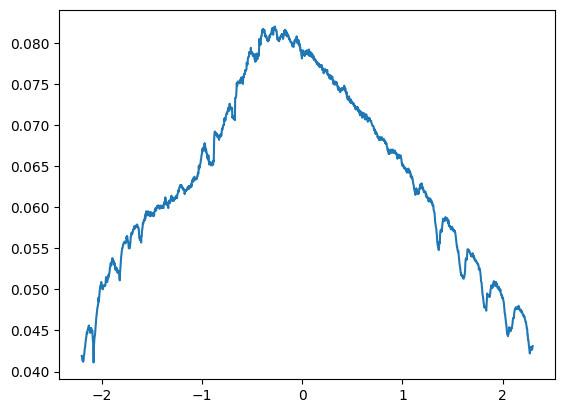

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Multi_25.txt', skiprows = 29,sep='\t')
 
data.columns = ['Timestamp', 'Channel A', 'Channel B', 'Unnamed']
data_1 = data.drop('Channel B', axis=1)
data_2 = data_1.drop('Unnamed', axis=1)
data_2['Channel A'] = pd.to_numeric(data_2["Channel A"], errors='coerce')
data_3 = data_2.dropna()
#print(data_3)
data_4 = data_3.to_numpy()

lin_v = 1.1/25

data_4[:,0] = data_4[:,0]*lin_v  #dist

trial1_arr = data_4[data_4[:, 0]<6.2]
trial_arr = trial1_arr[trial1_arr[:,0]>1.7]

data_zf = trial_arr[:,0]-3.9
data_T = trial_arr[:,1]

rpm = 10/(2/(60*lin_v))
print("rotation per minute is:", rpm)

plt.plot(data_zf, data_T)
plt.show()


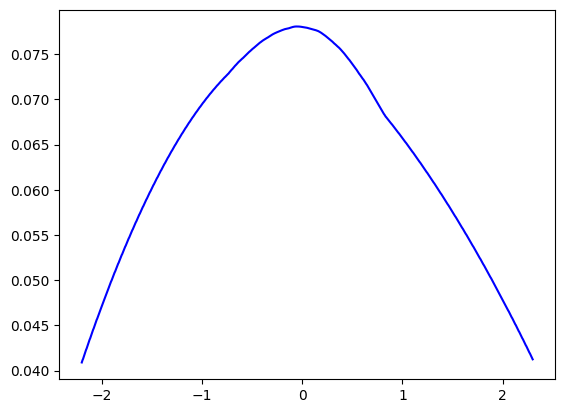

In [22]:
from scipy.signal import savgol_filter

w = savgol_filter(data_T, 1000, 2)
plt.plot(data_zf, w, 'b')  # smooth by filter

[-0.84537864  0.04451253]


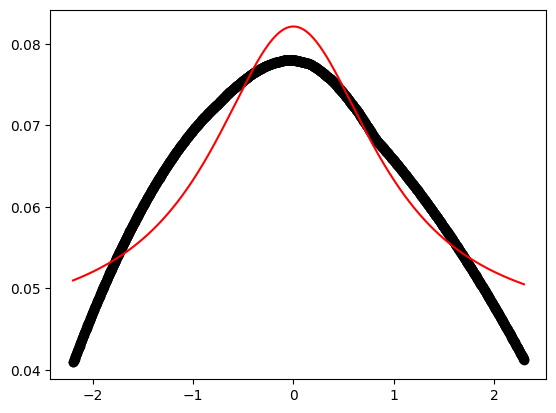

In [23]:
from scipy.optimize import curve_fit

def open_ap(z, del_psi0, N):
    return N - N*del_psi0/(z**2+1)

def closed_ap(z, del_psi0, del_phi0, N):
    return N + N*4*del_phi0*z/((z**2+9)*(z**2+1)) - N*del_psi0/(z**2+1)

popt, pcov = curve_fit(open_ap, data_zf, w)


print(popt)


plt.plot(data_zf, w, 'ko', label="Observed data points")


plt.plot(data_zf, open_ap(data_zf, *popt), 'r-', label="Fitted Curve")